# Preliminary Tasks

In [467]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from datetime import datetime 
from sklearn.preprocessing import MinMaxScaler,StandardScaler,power_transform
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
%matplotlib inline

from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style(theme = 'solarizedl',grid = False)

## Reading Data

In [550]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test_bqCt9Pv.csv')

In [551]:
train_data.columns = [i.lower().replace('.','_') for i in train_data.columns]
test_data.columns = [i.lower().replace('.','_') for i in test_data.columns]

In [552]:
id_columns = [i for i in train_data.columns if '_id' in i]
flag_cols = [i for i in train_data.columns if 'flag' in i]

## Functions

In [538]:
# Function to find the best n_estimators for xgboost model
def best_n_est(params,train,test,early_stopping_rounds = 100,verbose = 1):
    num_rounds = 20000
    np.random.seed(47)
    watchlist = [(train,'train'),(test, 'eval')]
    model = xgboost.train(params, 
                      train,
                      num_rounds,
                      watchlist,
                      early_stopping_rounds=early_stopping_rounds,
                      verbose_eval = verbose)
    
    return model.best_iteration

In [440]:
def convert(df, columns):
    for i in columns:
        df[i] = lb.fit_transform(df[i])
    return df

In [323]:
def my_plot_importance(booster, figsize, **kwargs): 
    from matplotlib import pyplot as plt
    from xgboost import plot_importance
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, **kwargs)

In [511]:
def normalize_cols(df, cols):
    data = df.copy()
    for i in cols:
        data.loc[:,i] = power_transform(data[i].values.reshape(-1,1), method = 'yeo-johnson')[:,0] * 10
    return data

# Data Cleaning

In [555]:
train_data.isnull().sum(),test_data.isnull().sum()

(uniqueid                                  0
 disbursed_amount                          0
 asset_cost                                0
 ltv                                       0
 branch_id                                 0
 supplier_id                               0
 manufacturer_id                           0
 current_pincode_id                        0
 date_of_birth                             0
 employment_type                        7661
 disbursaldate                             0
 state_id                                  0
 employee_code_id                          0
 mobileno_avl_flag                         0
 aadhar_flag                               0
 pan_flag                                  0
 voterid_flag                              0
 driving_flag                              0
 passport_flag                             0
 perform_cns_score                         0
 perform_cns_score_description             0
 pri_no_of_accts                           0
 pri_activ

# Exploration

In [556]:
exp_cols = [i for i in train_data.columns if 'pri' in i] + [i for i in train_data.columns if 'sec' in i]

In [557]:
# Train data description
pandas_profiling.ProfileReport(train_data[exp_cols])

Number of variables,14
Number of observations,233154
Total Missing (%),0.0%
Total size in memory,24.9 MiB
Average record size in memory,112.0 B
Numeric,11
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,3


In [558]:
# Test data description
pandas_profiling.ProfileReport(test_data[exp_cols])

Number of variables,14
Number of observations,112392
Total Missing (%),0.0%
Total size in memory,12.0 MiB
Average record size in memory,112.0 B
Numeric,11
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,3


## Categorical columns exploration
<br>

* mobileno_avl_flag not required due to low cardinality

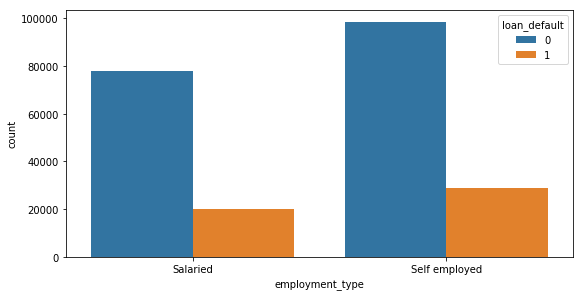

In [5]:
plt.figure(figsize = [20,10])
plt.subplot(221)
sns.countplot(train_data['employment_type'],hue = train_data['loan_default'])
plt.show()

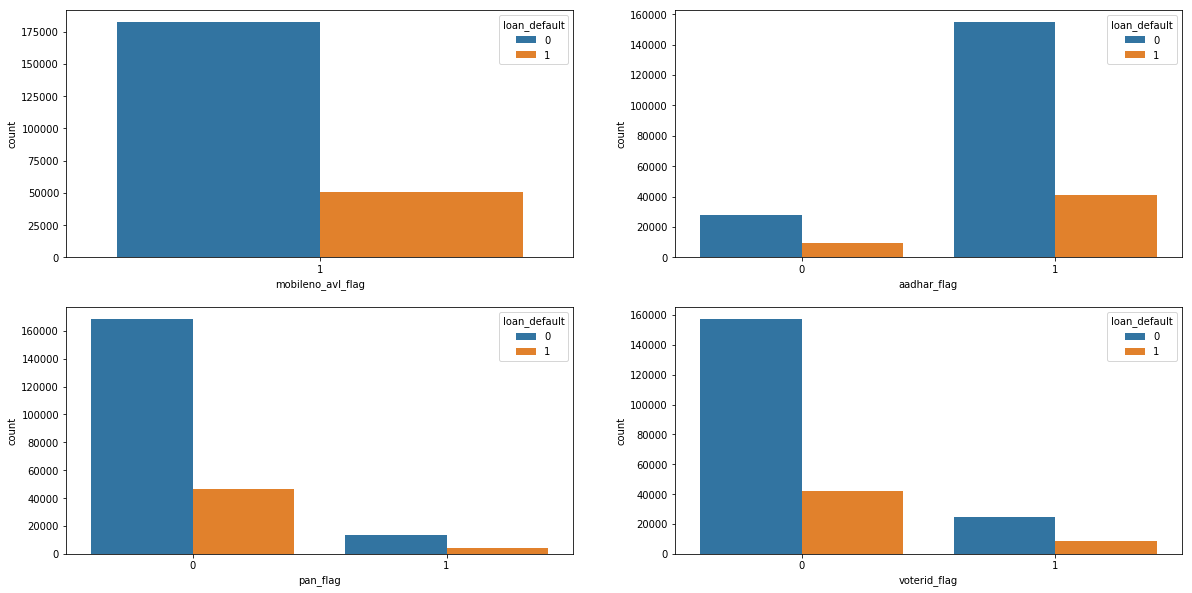

In [6]:
plt.figure(figsize = [20,10])
plt.subplot(221)
sns.countplot(train_data[flag_cols[0]],hue = train_data['loan_default'])
plt.subplot(222)
sns.countplot(train_data[flag_cols[1]],hue = train_data['loan_default'])
plt.subplot(223)
sns.countplot(train_data[flag_cols[2]],hue = train_data['loan_default'])
plt.subplot(224)
sns.countplot(train_data[flag_cols[3]],hue = train_data['loan_default'])
plt.show()

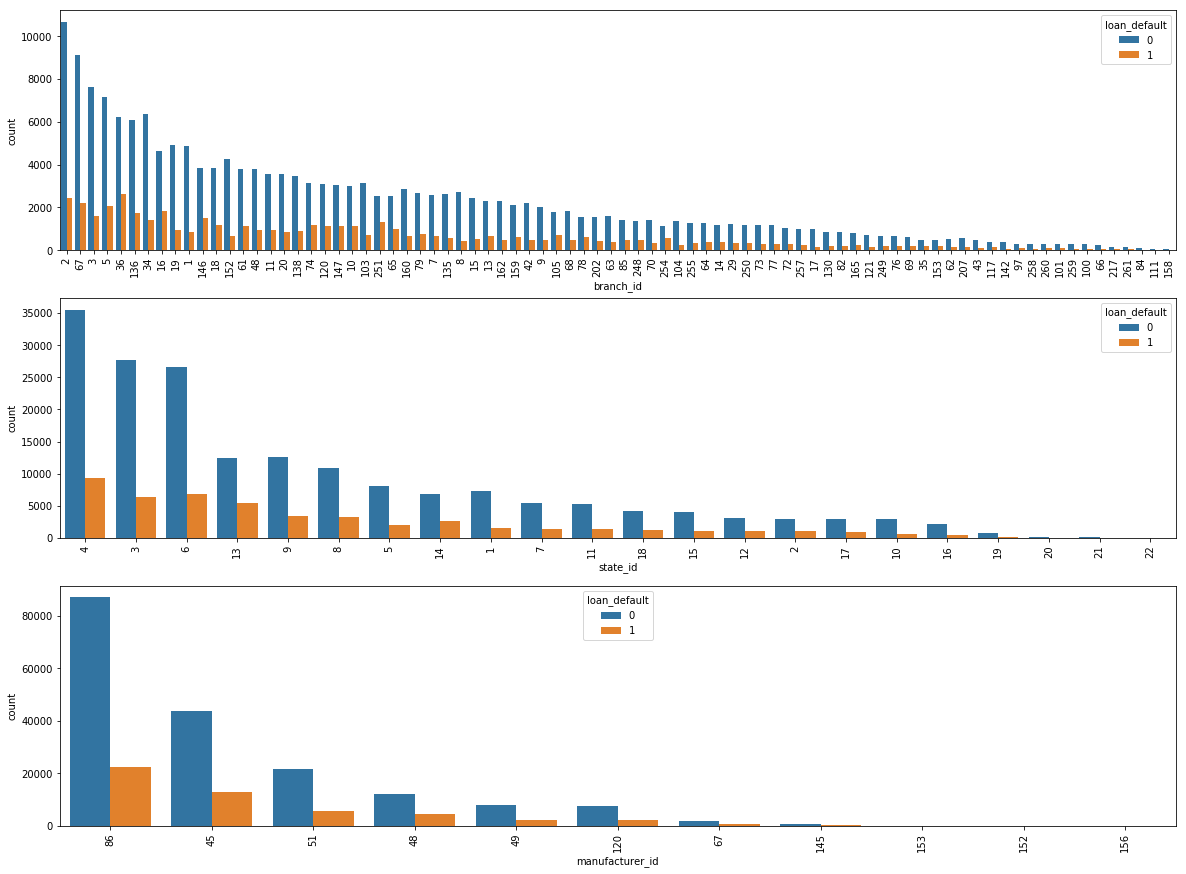

In [7]:
plt.figure(figsize = [20,15])
plt.subplot(311)
sns.countplot(train_data['branch_id'], order =train_data['branch_id'].value_counts().index, hue= train_data['loan_default'])
plt.xticks(rotation = 'vertical')

plt.subplot(312)
sns.countplot(train_data['state_id'], order =train_data['state_id'].value_counts().index, hue= train_data['loan_default'])
plt.xticks(rotation = 'vertical')

plt.subplot(313)
sns.countplot(train_data['manufacturer_id'], order =train_data['manufacturer_id'].value_counts().index, hue= train_data['loan_default'])
plt.xticks(rotation = 'vertical')
plt.show()

In [361]:
train_data['perform_cns_score_description'].value_counts()

No Bureau History Available                                116950
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9201
M-Very High Risk                                             8776
F-Low Risk                                                   8485
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3988
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3748
Not Scored: Not Enough Info available on the customer        3672
Not Scored

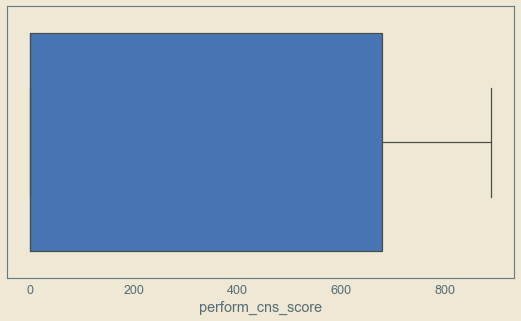

In [476]:
plt.figure(figsize = [20,5])
plt.subplot(121)
sns.boxplot(train_data['perform_cns_score'])
plt.show()

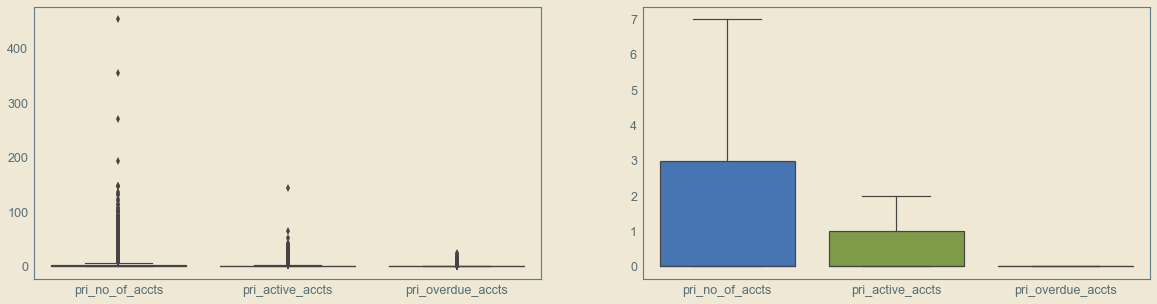

In [477]:
plt.figure(figsize = [20,5])
plt.subplot(121)
sns.boxplot(data = train_data[[i for i in train_data.columns if 'pri' in i][0:3]], orient = 'v')
plt.subplot(122)
sns.boxplot(data = train_data[[i for i in train_data.columns if 'pri' in i][0:3]], orient = 'v',showfliers = False)
plt.show()

* **outlier for pri_disbured_amount at 1e9**
* **outlier for pri_current_balance below 0**

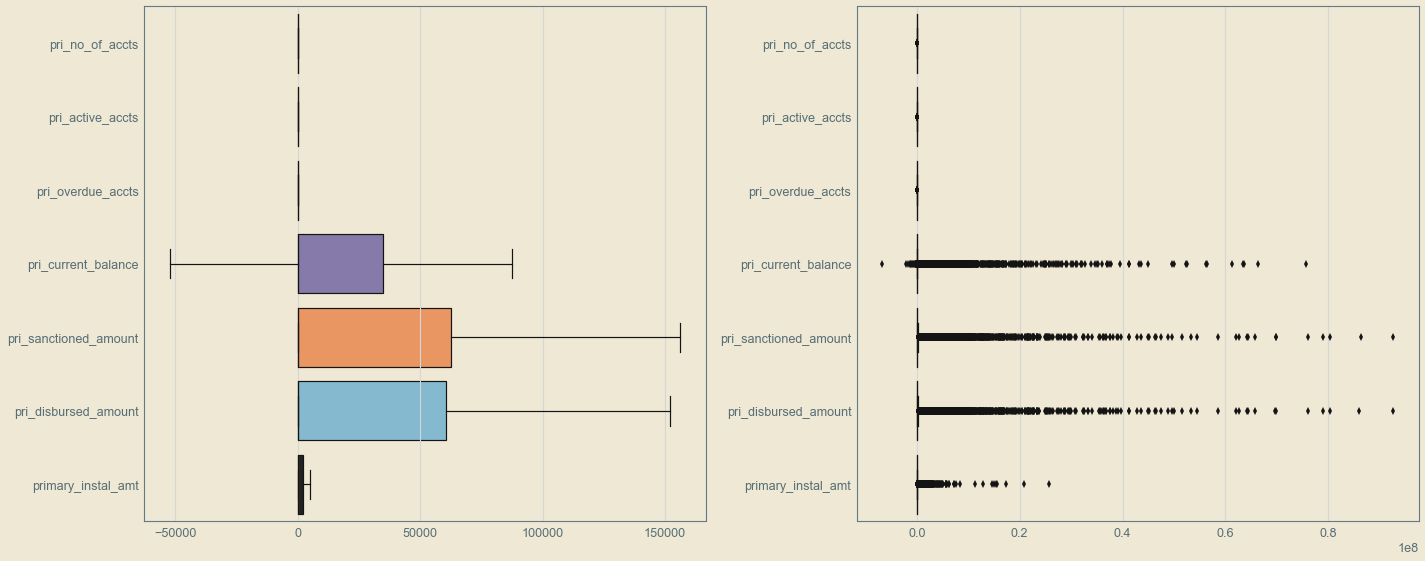

In [374]:
plt.figure(figsize = [20,8])
plt.subplot(121)
sns.boxplot(data = train_data[[i for i in train_data.columns if 'pri' in i]][train_data.pri_disbursed_amount < 1e8], 
            orient = 'h',showfliers = False)
plt.subplot(122)
sns.boxplot(data = train_data[[i for i in train_data.columns if 'pri' in i]][train_data.pri_disbursed_amount < 1e8], 
            orient = 'h',showfliers = True)

plt.tight_layout()
plt.show()

C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log1p
  
C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  


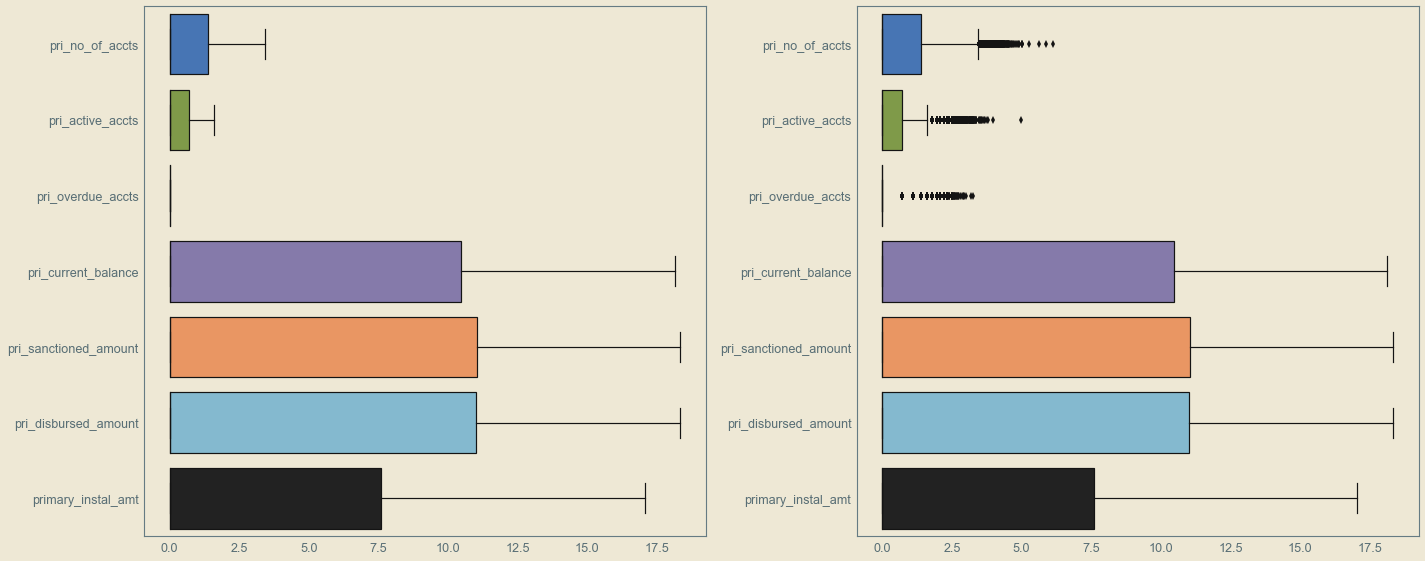

In [481]:
plt.figure(figsize = [20,8])
plt.subplot(121)
sns.boxplot(data = np.log1p(train_data[[i for i in train_data.columns if 'pri' in i]][train_data.pri_disbursed_amount < 1e8]), 
            orient = 'h',showfliers = False)
plt.subplot(122)
sns.boxplot(data = np.log1p(train_data[[i for i in train_data.columns if 'pri' in i]][train_data.pri_disbursed_amount < 1e8]), 
            orient = 'h',showfliers = True)

plt.tight_layout()
plt.show()

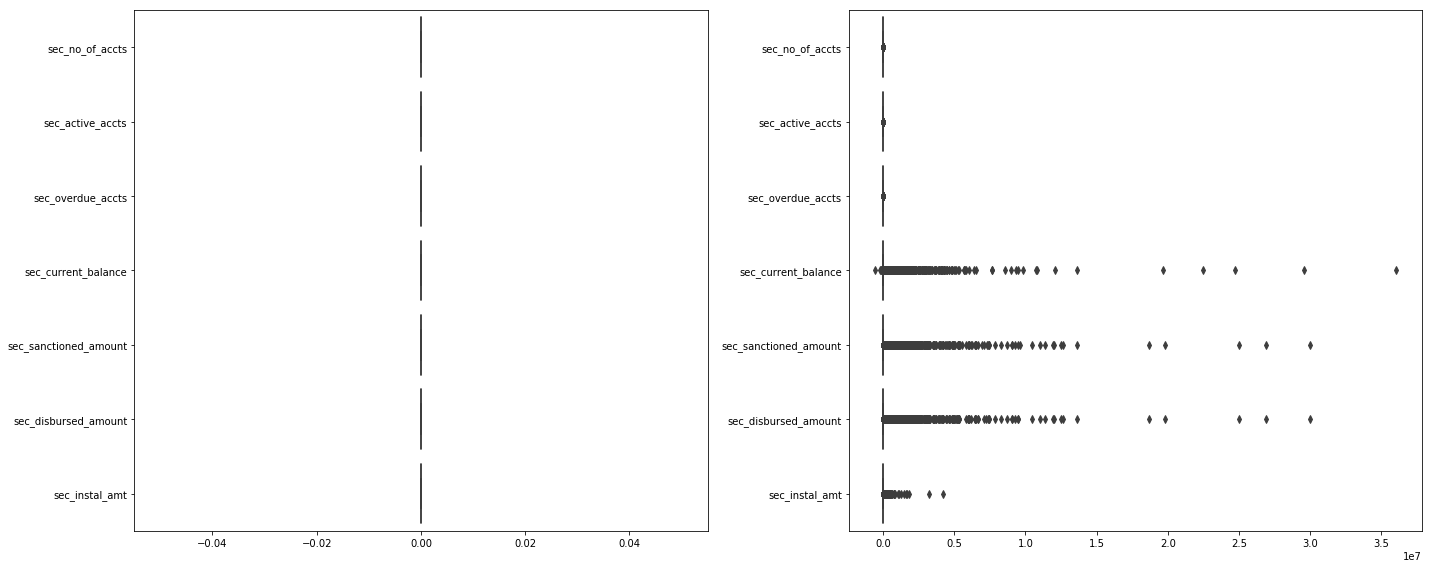

In [67]:
plt.figure(figsize = [20,8])
plt.subplot(121)
sns.boxplot(data = train_data[[i for i in train_data.columns if 'sec' in i]], 
            orient = 'h',showfliers = False)
plt.subplot(122)
sns.boxplot(data = train_data[[i for i in train_data.columns if 'sec' in i]], 
            orient = 'h',showfliers = True)

plt.tight_layout()
plt.show()

C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log1p
  
C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log1p
  


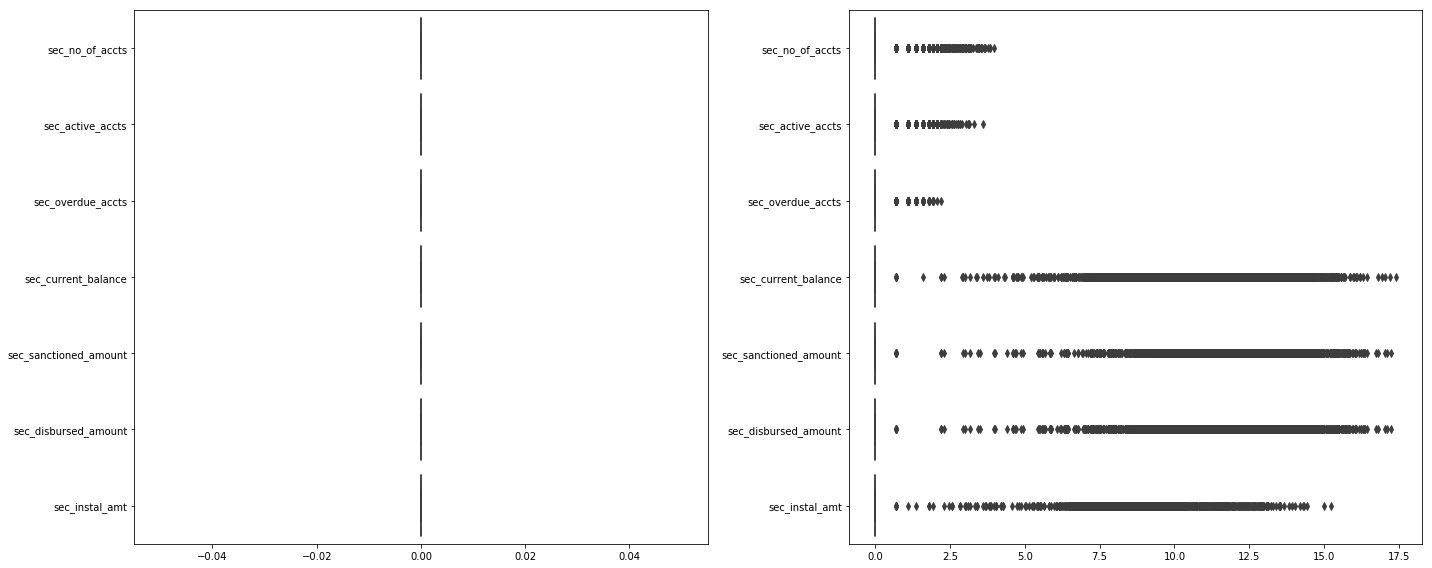

In [68]:
plt.figure(figsize = [20,8])
plt.subplot(121)
sns.boxplot(data = np.log1p(train_data[[i for i in train_data.columns if 'sec' in i]][train_data.pri_disbursed_amount < 1e8]), 
            orient = 'h',showfliers = False)
plt.subplot(122)
sns.boxplot(data = np.log1p(train_data[[i for i in train_data.columns if 'sec' in i]][train_data.pri_disbursed_amount < 1e8]), 
            orient = 'h',showfliers = True)

plt.tight_layout()
plt.show()

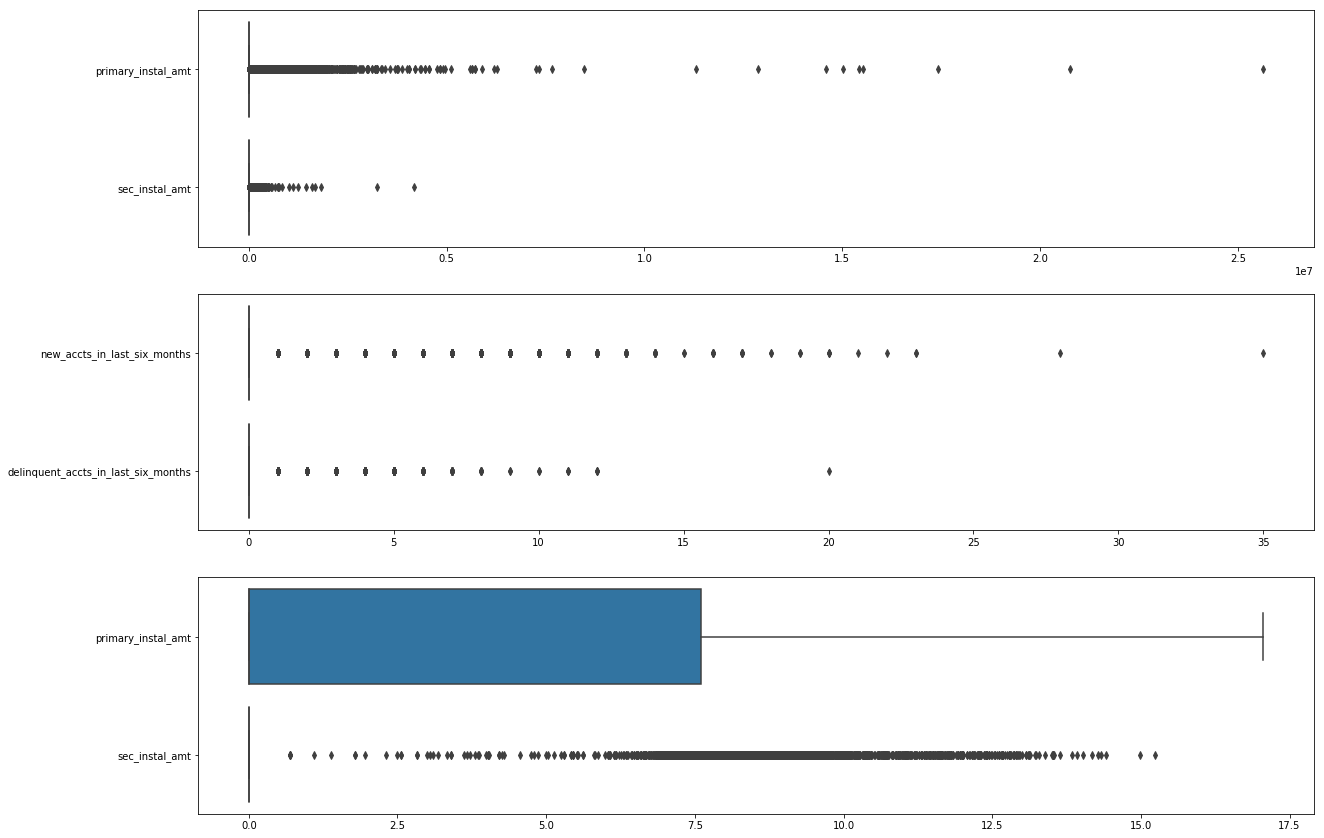

In [84]:
plt.figure(figsize = [20,20])
plt.subplot(411)
sns.boxplot(data = train_data[['primary_instal_amt','sec_instal_amt']], 
            orient = 'h',showfliers = True)
plt.subplot(412)
sns.boxplot(data = train_data[['new_accts_in_last_six_months','delinquent_accts_in_last_six_months']], 
            orient = 'h',showfliers = True)
plt.subplot(413)
sns.boxplot(data = np.log1p(train_data[['primary_instal_amt','sec_instal_amt']]), 
            orient = 'h',showfliers = True)

In [134]:
def convert_col(df, cols):
    data = df.copy()
    for i in cols:
        data[i] = data[i].replace(regex=True,to_replace=r'\D',value=r' ').apply(lambda x: int(x.strip().split('    ')[0])*12 + int(x.strip().split('    ')[1]))
    return data

In [512]:
# convertin
train_data_1 = convert_col(train_data, ['credit_history_length','average_acct_age'])
test_data_1 = convert_col(test_data, ['credit_history_length','average_acct_age'])

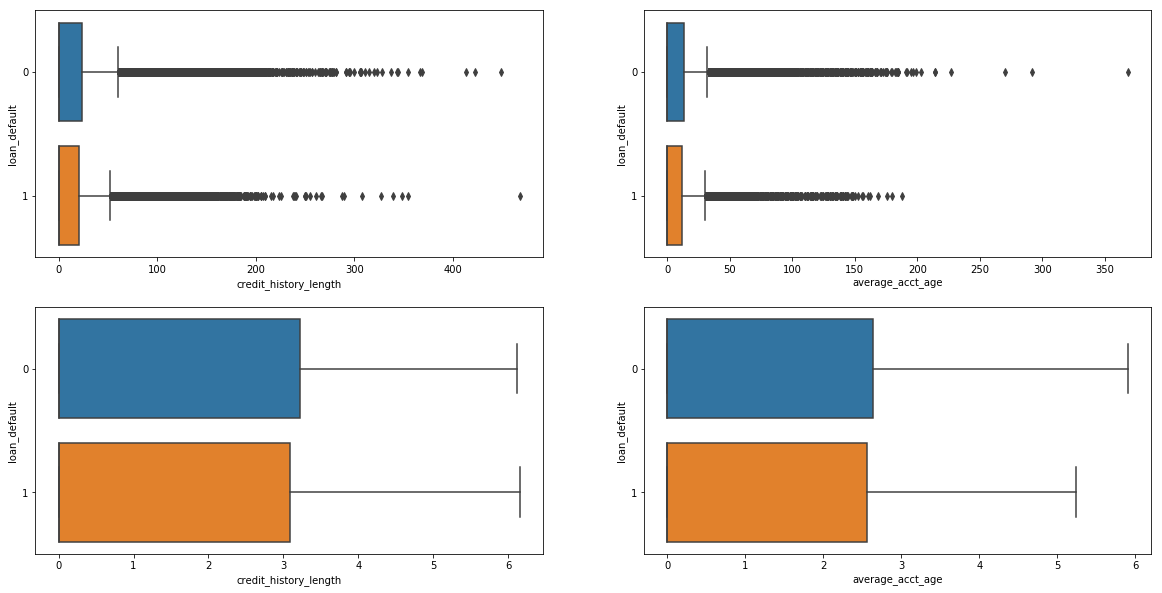

In [147]:
plt.figure(figsize = [20,10])
plt.subplot(221)
sns.boxplot(x = 'credit_history_length',data = train_data_1, orient = 'h',showfliers = True, y = 'loan_default')
plt.subplot(222)
sns.boxplot(x = 'average_acct_age',data = train_data_1, orient = 'h',showfliers = True, y = 'loan_default')

plt.subplot(223)
sns.boxplot(x = np.log1p(train_data_1['credit_history_length']), orient = 'h',showfliers = True, y = train_data_1['loan_default'])
plt.subplot(224)
sns.boxplot(x = np.log1p(train_data_1['average_acct_age']), orient = 'h',showfliers = True, y = train_data_1['loan_default'])

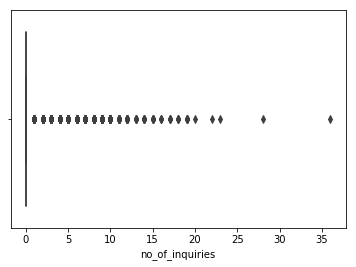

In [149]:
sns.boxplot(train_data_1['no_of_inquiries'])

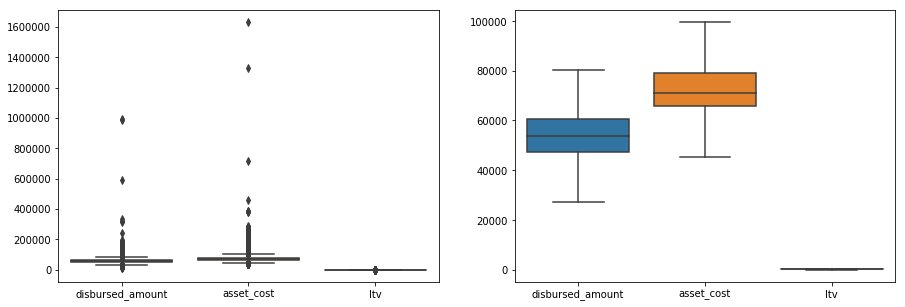

In [321]:
plt.figure(figsize = [15,5])
plt.subplot(121)
sns.boxplot(data = train_data_1[['disbursed_amount','asset_cost','ltv']])
plt.subplot(122)
sns.boxplot(data = train_data_1[['disbursed_amount','asset_cost','ltv']],showfliers = False)

In [184]:
train_data_1.person_age = np.asarray(list(map(lambda x: x.days/365, (train_data_1.disbursaldate.apply(lambda x: datetime.strptime(x,'%d-%m-%y')) - train_data_1.date_of_birth.apply(lambda x: datetime.strptime(x,'%d-%m-%y'))))))
test_data_1.person_age = np.asarray(list(map(lambda x: x.days/365, (test_data_1.disbursaldate.apply(lambda x: datetime.strptime(x,'%d-%m-%y')) - test_data_1.date_of_birth.apply(lambda x: datetime.strptime(x,'%d-%m-%y'))))))

In [203]:
train_data_1[train_data_1.date_of_birth.apply(lambda x: [int(i) for i in x.split('-')][2]) > 19].date_of_birth.apply(lambda x: [int(i) for i in x.split('-')][2]).unique()

[49,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

In [197]:
[int(i) for i in train_data_1.loc[,'date_of_birth'].split('-')][2]

68

In [189]:
pd.to_datetime(train_data_1.loc[9,'date_of_birth'])

Timestamp('2068-01-06 00:00:00')

In [187]:
train_data_1[train_data_1.person_age < 0][['disbursaldate','date_of_birth']]

,disbursaldate,date_of_birth
9,16-09-18,01-06-68
26,16-08-18,02-08-68
32,12-09-18,01-06-66
59,24-08-18,01-06-64
68,19-09-18,01-01-67
72,13-10-18,01-01-67
97,23-10-18,01-01-68
111,08-08-18,01-01-67
128,18-09-18,01-01-62
167,22-10-18,01-05-65


# Feature Engineering

In [513]:
# Converting columns
cols = [i for i in train_data.columns if 'pri' in i] + [i for i in train_data.columns if 'sec' in i] + \
        ['primary_instal_amt','sec_instal_amt','credit_history_length','average_acct_age','disbursed_amount','asset_cost'] 
train_cols = [i for i in train_data_1.columns if i not in ['uniqueid','perform_cns_score','date_of_birth','employment_type','disbursaldate','perform_cns_score_description','loan_default']]
train_data_1 = normalize_cols(train_data_1, cols)
test_data_1 = normalize_cols(test_data_1,cols)

C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\sklearn\preprocessing\data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\sklearn\preprocessing\data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\sklearn\preprocessing\data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\sklearn\preprocessing\data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

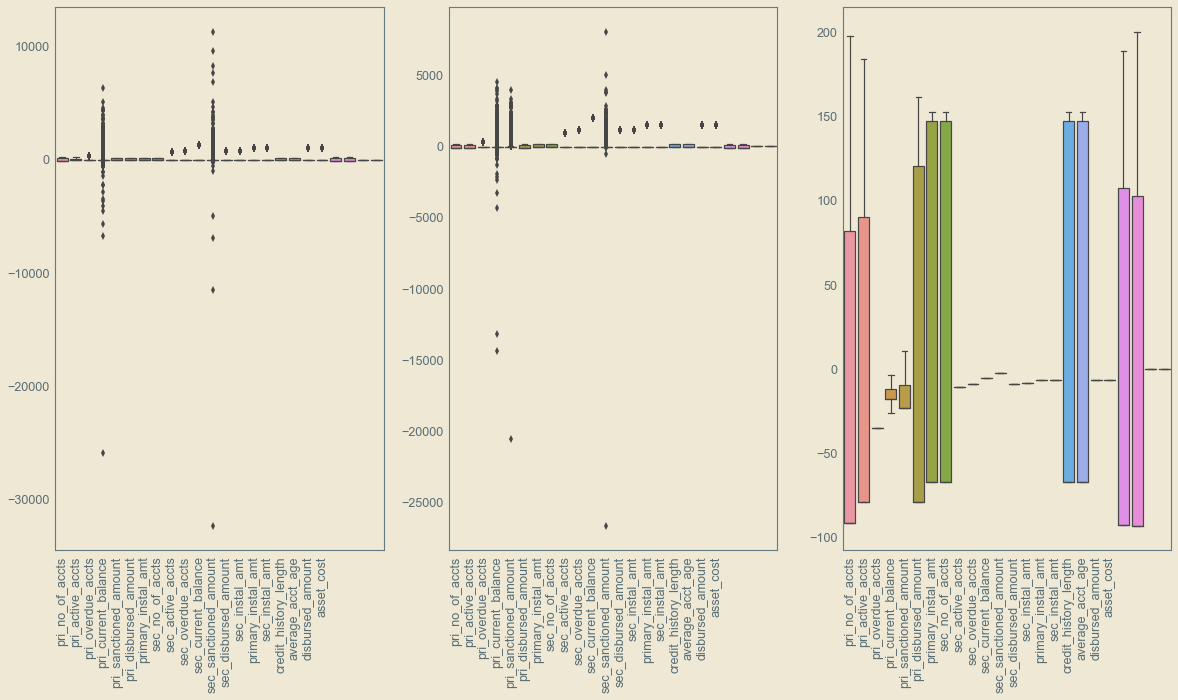

In [510]:
plt.figure(figsize = (20, 10))
plt.subplot(131)
sns.boxplot(data = train_data_1[cols]*100)
plt.xticks(rotation = 'vertical')
plt.subplot(132)
sns.boxplot(data = test_data_1[cols]*100)
plt.xticks(rotation = 'vertical')
plt.subplot(133)
sns.boxplot(data = test_data_1[cols]* 100,showfliers = False)
plt.xticks(rotation = 'vertical')

In [384]:
train_data_1[['perform_cns_score','perform_cns_score_description']].groupby('perform_cns_score_description').describe()

perform_cns_score  \
                                                               count   
perform_cns_score_description                                          
A-Very Low Risk                                              14124.0   
B-Very Low Risk                                               9201.0   
C-Very Low Risk                                              16045.0   
D-Very Low Risk                                              11358.0   
E-Low Risk                                                    5821.0   
F-Low Risk                                                    8485.0   
G-Low Risk                                                    3988.0   
H-Medium Risk                                                 6855.0   
I-Medium Risk                                                 5557.0   
J-High Risk                                                   3748.0   
K-High Risk                                                   8277.0   
L-Very High Risk                                              1134.0   
M-Very High Risk                                              8776.0   
No Bureau History Available                                 116950.0   
Not Scored: More than 50 active Accounts found                   3.0   
Not Scored: No Activity seen on the customer (I...            2885.0   
Not Scored: No Updates available in last 36 months            1534.0   
Not Scored: Not Enough Info available on the cu...            3672.0   
Not Scored: Only a Guarantor                                   976.0   
Not Scored: Sufficient History Not Available                  3765.0   

                                                                           \
                                                          mean        std   
perform_cns_score_description                                               
A-Very Low Risk                                     827.662631   8.823007   
B-Very Low Risk                                     774.183893  11.822008   
C-Very Low Risk                                     741.899221   6.771192   
D-Very Low Risk                                     715.958091   8.845807   
E-Low Risk                                          691.517437   7.682191   
F-Low Risk                                          666.064467  10.147717   
G-Low Risk                                          640.853561   5.541654   
H-Medium Risk                                       617.031947   8.324398   
I-Medium Risk                                       586.832644   9.381104   
J-High Risk                                         549.876734  14.373929   
K-High Risk                                         440.594177  45.119794   
L-Very High Risk                                    326.601411  15.135395   
M-Very High Risk                                    300.000000   0.000000   
No Bureau History Available                           0.000000   0.000000   
Not Scored: More than 50 active Accounts found       11.000000   0.000000   
Not Scored: No Activity seen on the customer (I...   16.000000   0.000000   
Not Scored: No Updates available in last 36 months   18.000000   0.000000   
Not Scored: Not Enough Info available on the cu...   17.000000   0.000000   
Not Scored: Only a Guarantor                         14.000000   0.000000   
Not Scored: Sufficient History Not Available         15.000000   0.000000   

                                                                          \
                                                      min     25%    50%   
perform_cns_score_description                                              
A-Very Low Risk                                     806.0  825.00  825.0   
B-Very Low Risk                                     761.0  763.00  772.0   
C-Very Low Risk                                     736.0  738.00  738.0   
D-Very Low Risk                                     706.0  708.00  712.0   
E-Low Risk                                          681.0  684.00  692.0   
F-Low Risk    

In [519]:
train_data_1.loc[:,'pri_by_score'] = train_data_1.pri_current_balance/train_data_1.score_1
test_data_1.loc[:,'pri_by_score'] = test_data_1.pri_current_balance/test_data_1.score_1
train_data_1.loc[:,'ltv_by_score'] = train_data_1.ltv/train_data_1.score_1
test_data_1.loc[:,'ltv_by_score'] = test_data_1.ltv/test_data_1.score_1

# Predictive modelling

In [520]:
from xgboost import XGBClassifier
import xgboost
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score,auc,roc_curve
from sklearn.model_selection import train_test_split

In [545]:
train_cols = [i for i in train_data_1.columns if i not in ['uniqueid','score_1','date_of_birth','employment_type','disbursaldate','perform_cns_score_description','loan_default']]

In [546]:
x_train,x_test, y_train,y_test = train_test_split(train_data_1[train_cols], train_data_1['loan_default'],
                                                  test_size = 0.2, 
                                                  shuffle = True, 
                                                  stratify = train_data_1['loan_default'])

In [549]:
params = {'eta': 0.05,
         'min_child_weight': 10,
         'subsample': 0.7,
         'colsample_bytree': 0.7,
         'scale_pos_weight': 2,
         'silent': 1,
         'max_depth':7,
         'objective': 'binary:logistic',
         'eval_metric': 'auc',
         'n_jobs': -1,
         'tree_method':'auto',
         'random_state': 42}
plst = list(params.items())
best_n_est(params,
           xgboost.DMatrix(x_train, y_train),
           xgboost.DMatrix(x_test, y_test),early_stopping_rounds=50)

[0]	train-auc:0.628196	eval-auc:0.617811
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.64187	eval-auc:0.627626
[2]	train-auc:0.647561	eval-auc:0.634667
[3]	train-auc:0.650231	eval-auc:0.637226
[4]	train-auc:0.654137	eval-auc:0.63957
[5]	train-auc:0.655815	eval-auc:0.640286
[6]	train-auc:0.655786	eval-auc:0.640216
[7]	train-auc:0.657214	eval-auc:0.641821
[8]	train-auc:0.65761	eval-auc:0.642359
[9]	train-auc:0.659202	eval-auc:0.643642
[10]	train-auc:0.660563	eval-auc:0.644378
[11]	train-auc:0.661027	eval-auc:0.644599
[12]	train-auc:0.661616	eval-auc:0.644822
[13]	train-auc:0.662271	eval-auc:0.645343
[14]	train-auc:0.663036	eval-auc:0.64579
[15]	train-auc:0.663602	eval-auc:0.646244
[16]	train-auc:0.664018	eval-auc:0.646449
[17]	train-auc:0.66429	eval-auc:0.646404
[18]	train-auc:0.664717	eval-auc:0.646746
[19]	train-auc:0.665909	eval-auc:0.64744
[20]	train-auc:0.666337	eval-auc:0.

[191]	train-auc:0.716805	eval-auc:0.66069
[192]	train-auc:0.716947	eval-auc:0.660676
[193]	train-auc:0.717169	eval-auc:0.660696
[194]	train-auc:0.717313	eval-auc:0.660727
[195]	train-auc:0.717593	eval-auc:0.660755
[196]	train-auc:0.717754	eval-auc:0.660735
[197]	train-auc:0.717996	eval-auc:0.66078
[198]	train-auc:0.718135	eval-auc:0.660803
[199]	train-auc:0.718265	eval-auc:0.660852
[200]	train-auc:0.718356	eval-auc:0.660878
[201]	train-auc:0.71841	eval-auc:0.660881
[202]	train-auc:0.718592	eval-auc:0.660832
[203]	train-auc:0.718674	eval-auc:0.660862
[204]	train-auc:0.718859	eval-auc:0.660899
[205]	train-auc:0.719056	eval-auc:0.660894
[206]	train-auc:0.719208	eval-auc:0.660925
[207]	train-auc:0.719388	eval-auc:0.660935
[208]	train-auc:0.719679	eval-auc:0.660967
[209]	train-auc:0.719778	eval-auc:0.660933
[210]	train-auc:0.719854	eval-auc:0.660941
[211]	train-auc:0.719945	eval-auc:0.660968
[212]	train-auc:0.720268	eval-auc:0.660976
[213]	train-auc:0.72054	eval-auc:0.661027
[214]	train-auc

KeyboardInterrupt: 

In [534]:
# params = {'tree_method' : 'gpu_hist'}
xg_model = XGBClassifier(max_depth = 5, n_estimators = 500,
                         random_state = 42, scale_pos_weight = 3.622,n_jobs = 6)
xg_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=6, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=3.622,
       seed=None, silent=True, subsample=1)

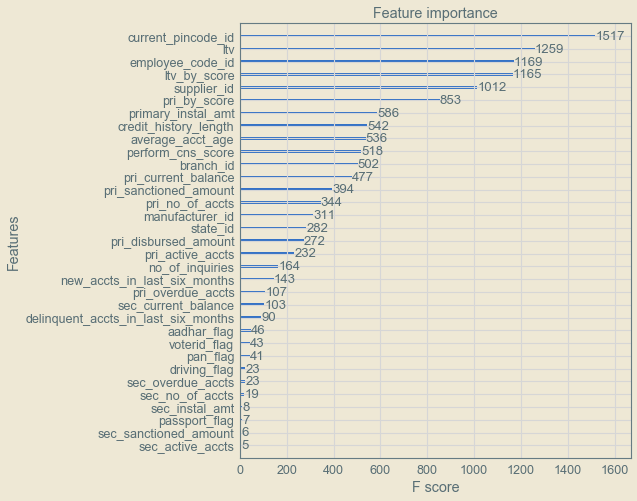

In [535]:
my_plot_importance(xg_model,[7,8])

In [536]:
predictions = xg_model.predict(x_test)

In [537]:
print(accuracy_score(y_test, predictions),
precision_score(y_test, predictions))
fpr, tpr, thresholds = roc_curve(y_test, np.asarray([i[1] for i in list(xg_model.predict_proba(x_test))]), pos_label=1)
auc(fpr, tpr)

0.6081576633569943 0.3051544420005738


0.6606554828539029

# Submission

In [528]:
output_no = input()

2


In [529]:
x_holdout = pd.get_dummies(test_data_1[train_cols])
test_data_1['prediction'] = xg_model.predict_proba(x_holdout)[:,1]
test_data_1['loan_default'] = test_data_1['prediction']
temp = test_data_1[['uniqueid','loan_default']]
temp.columns = ['UniqueID','loan_default']
temp.to_csv('./output_%s.csv'%(output_no), index=False)
output = pd.read_csv('./output_%s.csv'%(output_no))

# Appendix

In [516]:
reg_train_data = pd.concat([train_data_1[train_data_1.perform_cns_score > 20],test_data_1[test_data_1.perform_cns_score > 20]],axis = 0)
reg_test_data = train_data_1[train_data_1.perform_cns_score  == 0]

train_x_reg, test_x_reg, train_y_reg, test_y_reg = train_test_split(reg_train_data[[i for i in train_cols if 'cns' not in i]], 
                                                                   reg_train_data['perform_cns_score'], test_size = 0.2)

C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=6,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [517]:
xgb_reg_model = XGBRegressor(n_estimators = 600, 
                         max_depth = 7,
                         random_state = 42, 
                         n_jobs = 6)
xgb_reg_model.fit(reg_train_data[[i for i in train_cols if 'cns' not in i]],reg_train_data['perform_cns_score'])

C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\as19238\AppData\Local\Continuum\anaconda3\envs\torch_env\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=600, n_jobs=6,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [518]:
train_data_1.loc[train_data_1.perform_cns_score  == 0, 'score_1'] = xgb_reg_model.predict(train_data_1[train_data_1.perform_cns_score  == 0][[i for i in train_cols if 'cns' not in i]])
test_data_1.loc[test_data_1.perform_cns_score  == 0, 'score_1'] = xgb_reg_model.predict(test_data_1[test_data_1.perform_cns_score  == 0][[i for i in train_cols if 'cns' not in i]])

train_data_1.loc[train_data_1.perform_cns_score > 0, 'score_1'] = train_data_1.loc[train_data_1.perform_cns_score > 0, 'perform_cns_score']
test_data_1.loc[test_data_1.perform_cns_score > 0, 'score_1'] = test_data_1.loc[test_data_1.perform_cns_score > 0, 'perform_cns_score']